In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import re, string, unicodedata
import nltk
import contractions
import inflect

import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

import re

from wordcloud import WordCloud, STOPWORDS

import nltk
# import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer


from sklearn import metrics
from sklearn.model_selection import train_test_split
# from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder

import scipy

from gensim import corpora
from gensim import corpora
from gensim.similarities.docsim import Similarity
from gensim import corpora, models, similarities

import pickle
import time

# Read Train Split and Validation Data

In [177]:
rev_busi_Pho= pd.read_csv('../data/filtered_reviews_in_Phonex.csv', parse_dates=["date"])

train_df  = pickle.load(open('../data/train_df.pkl', "rb"))
valid_df = pickle.load(open('../data/valid_df.pkl', "rb"))
test_df = pickle.load(open('../data/test_df.pkl', "rb"))

In [178]:
train_df = train_df.merge(rev_busi_Pho[["review_id", "user_id", "business_id", "text"]], how = "left", on = ["user_id", "business_id"])
valid_df = valid_df.merge(rev_busi_Pho[["review_id", "user_id", "business_id", "text"]], how = "left", on = ["user_id", "business_id"])
test_df  = test_df.merge(rev_busi_Pho[["review_id", "user_id", "business_id", "text"]], how = "left", on = ["user_id", "business_id"])

train_df.head(1)

,user_id,business_id,stars,review_id,text
0,--2HUmLkcNHZp0xw6AMBPg,yX0pOWG_Be9TjGnm0aihVA,5.0,tfi5EOpqZw637p3AJtOUMg,Obsessed with their chicken salad and sweet fr...


In [4]:
train_df.shape
valid_df.shape
test_df.shape

(180559, 5)

(19500, 5)

(19500, 5)

In [179]:
print("unique users in training set:", train_df["user_id"].nunique())
print("unique businesses in training set:", train_df["business_id"].nunique())
print("unique users in test set:", test_df["user_id"].nunique())
print("unique businesses in test set:", test_df["business_id"].nunique())

unique users in training set: 19683
unique businesses in training set: 1728
unique users in test set: 19500
unique businesses in test set: 1672


# Content-based Model, NLP (Tf-idf)

### - Combine reviews of each business_id as its document 

In [6]:
train_df.head(1)
text_train_df = train_df.groupby(["business_id"])["text"].apply(lambda x: x.str.cat()).reset_index()
len(text_train_df)
text_train_df.head(1)

,user_id,business_id,stars,review_id,text
0,--2HUmLkcNHZp0xw6AMBPg,yX0pOWG_Be9TjGnm0aihVA,5.0,tfi5EOpqZw637p3AJtOUMg,Obsessed with their chicken salad and sweet fr...


1728

,business_id,text
0,-050d_XIor1NpCuWkbIVaQ,Great Food. Great Coffee. Great Service. Amazi...


### - Generate Wordcloud

In [7]:
# gather all words together
all_text = ""
all_snippets = text_train_df["text"].values

for snippet in all_snippets:
    all_text += snippet

# plot Wordcloud
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white',width=6000,height=6000).generate(all_text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### - Text Prepocessing

In [6]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
            
    return new_words

def remove_special(words):
    """Remove special signs like &*"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[-,$()#+&*]', '', word)
        if new_word != '':
            new_words.append(new_word)
            
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
            
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""  
    stopwords = nltk.corpus.stopwords.words('english')
    myStopWords = []
    stopwords.extend(myStopWords)
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
            
    return new_words

def to_lowercase(words):
    """Convert words to lowercase"""
    new_words=[]
    for word in words:
        new_words.append(word.lower())
        
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
        
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
        
    return lemmas

def normalize_lemmatize(words):
    words = remove_special(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    words = stem_words(words)
    words = lemmatize_verbs(words)
    
    return words


In [7]:
def get_processed(sample):
    processed = pd.DataFrame(data=[],columns = ['business_id', 'text'])
    new_texts = []

    for i in range(0, len(sample)):
        business_id = sample['business_id'].iloc[i]
        words = nltk.word_tokenize(sample['text'].iloc[i])
        text = ' '.join(normalize_lemmatize(words))
        dfnew = pd.DataFrame([[business_id, text]], columns=['business_id', 'text'])
        new_texts.append(text)
        processed = processed.append(dfnew,ignore_index = True)

    return processed

In [9]:
# This takes lots of time, 
# You may just read_pickle here after the initial run

df_texts_train = get_processed(text_train_df)
df_texts_train.to_pickle('../data/text_train_df.pkl')

#df_texts_train = pickle.load(open('../data/text_train_df.pkl', "rb"))


### - Cosine Similarity

In [10]:
def get_tfidf_matrix(processed):
    '''
    get the Tf-Idf matrix of processed texts for business reviews
    
    '''
    TV = TfidfVectorizer(stop_words = "english")
    processed["text"] = processed["text"].fillna('')
    tfidf_matrix = TV.fit_transform((processed["text"]))
    
    return tfidf_matrix

def get_cos_sim_matrix(tfidf_matrix, n):
    '''
    use truncated SVD to reduce dimensions to n 
    @n: the dimensions to keep
    '''
    SVD = TruncatedSVD(n_components = n , random_state = 42) # 42 is the ultimate answer to everything
    tfidf_truncated = SVD.fit_transform(tfidf_matrix)
    cosine_sim = cosine_similarity(tfidf_truncated, tfidf_truncated)
    
    return cosine_sim


### - Dimension Reduction

<BarContainer object of 1727 artists>

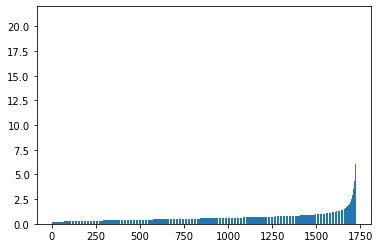

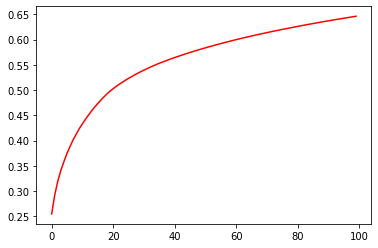

In [120]:
tfidf_matrix = get_tfidf_matrix(df_texts_train)
u, s, vt  = scipy.sparse.linalg.svds(tfidf_matrix, k = tfidf_matrix.shape[0]-1)
plt.bar(range(len(s)),s)
plt.show()

plt.plot(range(len(s))[:100], np.cumsum(sorted((s**2 / sum(s**2)),reverse = True)[:100]), "r" )
plt.show()

<BarContainer object of 50 artists>

Text(0.5, 1.0, 'Singular values of restaurant features')

Text(0.5, 0, 'Dimension')

Text(0, 0.5, 'Singular values')

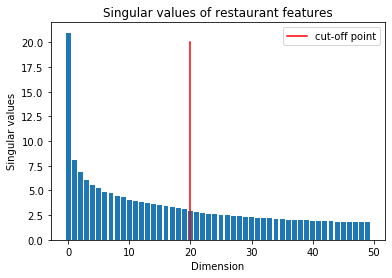

In [135]:
# u, s, vt  = np.linalg.svd(bus_df_subset.iloc[:,:])
plt.bar(range(50),np.sort(s)[::-1][:50])
plt.plot([20 for i in np.linspace(0,20,10)], np.linspace(0,20,10),"r", label = "cut-off point")
plt.title("Singular values of restaurant features")
plt.xlabel("Dimension")
plt.ylabel("Singular values")
plt.legend(loc = "best")
plt.show()

### - Here we choose n=20 

Text(0.5, 1.0, 'Singular values of restaurant features')

Text(0.5, 0, 'Dimension')

Text(0, 0.5, 'Singular values')

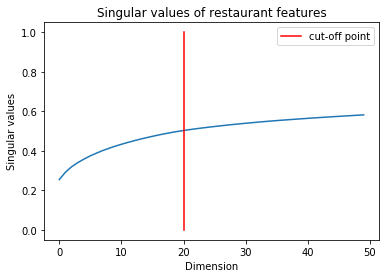

In [143]:
plt.plot(range(50), np.cumsum(np.sort(s)[::-1]**2/np.sum(np.sort(s)[::-1]**2))[:50] )
plt.plot([20 for i in np.linspace(0,1,10)], np.linspace(0,1,10),"r", label = "cut-off point")
plt.title("Singular values of restaurant features")
plt.xlabel("Dimension")
plt.ylabel("Singular values")
plt.legend(loc = "best")
plt.show()

In [11]:
### Generate Tf-idf vector space representation, and apply truncated SVD

tfidf_matrix = get_tfidf_matrix(df_texts_train)
cosine_sim = get_cos_sim_matrix(tfidf_matrix, 20)
df_sim = pd.DataFrame(cosine_sim, index=df_texts_train['business_id'].values, columns=df_texts_train['business_id'].values)
df_sim.head(1)
cosine_sim.shape

,-050d_XIor1NpCuWkbIVaQ,-0WegMt6Cy966qlDKhu6jA,-0tgMGl7D9B10YjSN2ujLA,-1UMR00eXtwaeh59pEiDjA,-45kMvS7h38CGaWugPY0rg,-8JaNeG3etLgOVyg2gOIiA,-9eNGMp8XiygI8t8QFuFWw,-A9sm-E6uQxWTJ_MuyOzFw,-Bdw-5H5C4AYSMGnAvmnzw,-BxWyEIQ6wypT-37MzZizQ,...,zSicVxnJHV8indit0oFuNw,zU63bs3Ofe8y1peOgOFJaA,zYZPpOqo_2YrLJLOmjlgPQ,zaBk2imYnk7rG7IdOMhRmA,zbrFk-4ejesAJD8EwcdHxg,zc1sur_MxkKkD6P8gYXQbg,zidkKI_N1OPxsiddTOQH_Q,znH36RmIAI4wcHy9WiEO5Q,zrTGcb83AsfyVTMrsCa65A,zwmps5SXn30g-f5wqg_r9A
-050d_XIor1NpCuWkbIVaQ,1.0,0.580148,0.577455,0.958394,0.691951,0.557193,0.649372,0.327343,0.719355,0.641419,...,0.969567,0.569617,0.38946,0.250388,0.529521,0.988208,0.342962,0.565981,0.662767,0.516715


(1728, 1728)

In [12]:
def get_recommendation_cos(reviews, business_id, user_id, df_sim, k):
    '''get the business_id_array that shows top_k greatest similarity to the specific business_id'''
    user_bids = reviews[reviews['user_id']==user_id]['business_id'].values
    df_user = df_sim.loc[df_sim.index.isin(user_bids), df_sim.columns == business_id]
    df_user_topk = df_user.sort_values(df_user.columns[0], ascending = False).iloc[:k]
    
    return np.array(df_user_topk.index.values)


def predict_rating(reviews, user_id, business_ids):
    '''predict the avg of the user's rating on business in business_ids'''
    scores = reviews.loc[(reviews.user_id == user_id) & (reviews.business_id.isin(business_ids))]["stars"].values
    
    return np.mean(scores)


def get_results_cos(reviews, reviews_test, business_id, user_id, df_sim, k):
    '''
    prediction on the business_id：avg the ratings on top_k business that shows similarity to the business_id
    actual on the business_id: the true rating 
    '''
    actual = reviews_test.loc[(reviews_test.user_id==user_id) & (reviews_test.business_id==business_id)]['stars'].values[0]
    business_ids = get_recommendation_cos(reviews, business_id, user_id, df_sim, k)
    prediction = predict_rating(reviews, user_id, business_ids)
    
    return actual, prediction

def get_review_processed(processed, reviews):
    reviews_processed = reviews.loc[reviews.business_id.isin(processed.business_id)]\
                                                       .reset_index()\
                                                       .drop(columns=['index'])
    return reviews_processed

In [13]:
reviews_processed = get_review_processed(df_texts_train, train_df)
reviews_processed.head()

,user_id,business_id,stars,review_id,text
0,--2HUmLkcNHZp0xw6AMBPg,yX0pOWG_Be9TjGnm0aihVA,5.0,tfi5EOpqZw637p3AJtOUMg,Obsessed with their chicken salad and sweet fr...
1,--2HUmLkcNHZp0xw6AMBPg,u9R0_pvEkl7QGPJYH3j1sg,5.0,_FcKYC5R81v6SbSeaWxHNA,This place is INCREDIBLE. We just bought a ho...
2,--2HUmLkcNHZp0xw6AMBPg,cHdJXLlKNWixBXpDwEGb_A,5.0,wK3roBOGrakzjoX_o5nmBw,Pretty decent for something a little different...
3,--2HUmLkcNHZp0xw6AMBPg,LR_99E7tVUfxqemvcGkDzw,3.0,_d9cfYYjzuJwhLe5egMLIQ,This place has pretty decent food but their se...
4,--2HUmLkcNHZp0xw6AMBPg,lfyg98UFNYMVk18p6LIlkw,5.0,_yreTg27A_fsPb8uulhKtg,"Love this place. Amazing food, great selectio..."


In [14]:
def CB_predict(reviews, reviews_test, df_sim, k = 5):
    '''
    based on test_df 
    get a dataframe with each user on each business's true ratings and prediction ratings
    @k: int, top k similar businesses
    '''
    user_id_sample = reviews_test['user_id'].values
    busi_id_sample = reviews_test['business_id'].values
    
    actual = []
    predictions = []
    
    for i in range(len(reviews_test)):
        try:
            act, pred = get_results_cos(reviews, reviews_test, busi_id_sample[i], user_id_sample[i], df_sim, k)
            actual.append(act)
            predictions.append(pred)
            
        except:
            actual.append(np.nan)
            predictions.append(np.nan)
            
    return pd.DataFrame({"user_id": user_id_sample,
                         "business_id": busi_id_sample,
                         "true_ratings": actual,
                         "prediction_ratings":  predictions                        
                        })

### - Tuning parameters k

time elapsed: (seconds)
4312.54


optimal k (nearest neighbors):
     ks  sample_size      rmse       mae
4  45.0      19500.0  1.338007  1.004968


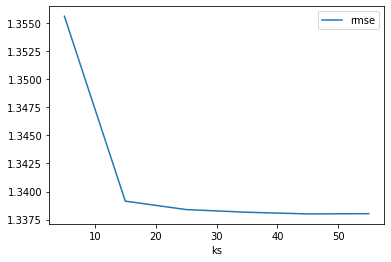

In [20]:
# # run this may take 2527.366 seconds
# # the result of this process:
# # optimal k (nearest neighbors): 3   35.0


t0 = time.time()
df_pred_results = pd.DataFrame(columns= ["ks", "sample_size", "rmse", "mae"])
sample_sizes = [len(valid_df)]
ks = [5, 15, 25, 35, 45, 55]

for sample_size in sample_sizes:
    for k in ks:
        valid = CB_predict(train_df, valid_df.sample(n = sample_size, random_state = 12), df_sim, k)
        rmse = mean_squared_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)**0.5
        mae =  mean_absolute_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)**0.5
        df_pred_results = df_pred_results.append({"ks": k, "sample_size": sample_size,
                                                  "rmse": rmse, "mae": mae}, ignore_index = True)
t1 = time.time()
print("time elapsed: (seconds)")
print(np.round(t1 - t0,3))

df_pred_results[df_pred_results["sample_size"] == sample_size].plot("ks", "rmse")
print("optimal k (nearest neighbors):")
print(df_pred_results.loc[df_pred_results["rmse"] == np.min(df_pred_results.rmse),])

# df_pred_results.to_csv("Content_Based_Filtering_Cosine_Evaluation.csv",index = False)

In [22]:
df_pred_results.to_csv("../data/Content_Based_Filtering_Cosine_Evaluation.csv",index = False)

(array([ 0., 10., 20., 30., 40., 50., 60.]),
 <a list of 7 Text xticklabel objects>)

(array([1.789, 1.79 , 1.791, 1.792, 1.793, 1.794, 1.795, 1.796, 1.797]),
 <a list of 9 Text yticklabel objects>)

Text(0.5, 0, 'k')

Text(0, 0.5, 'MSE')

Text(0.5, 1.0, 'Content Based Model (Tf-idf): k vs MSE')

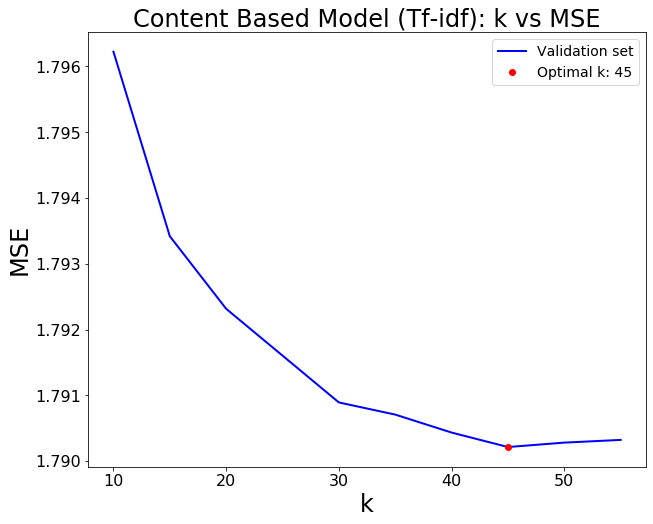

In [209]:
fig, ax = plt.subplots(figsize=(10,8))

optimal = df_pred_results.loc[df_pred_results["rmse"] == np.min(df_pred_results.rmse),]
# plt.figure()
plt.plot(df_pred_results["ks"][1:], np.round(df_pred_results["rmse"]**2,10)[1:], 
         label = "Validation set", linewidth = 2, color ="blue")
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.plot(optimal["ks"], np.round(optimal["rmse"]**2,10), "ro", label = "Optimal k: {}".format(45))
plt.legend(loc = "best", fontsize = 14)
plt.xlabel("k", fontsize = 24)
plt.ylabel("MSE", fontsize = 24)
plt.title("Content Based Model (Tf-idf): k vs MSE",fontsize=24)

In [186]:
### Prediction using the tuned parameters

t0 = time.time()
k = 45

valid = CB_predict(train_df, valid_df, df_sim, k)
mse = mean_squared_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)
mae =  mean_absolute_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)
t1 = time.time()
print("time elapsed: (seconds)")
print(np.round(t1 - t0,3))
print(mse)
valid.to_csv("Predictions_CB_tfidf.csv", index = False)


time elapsed: (seconds)
937.908
1.7902632606937823


# Content-Based Filtering (Business Attributes)

### This model leverages business non-reviews features to generate the similarity matrix

### We have done feature engineering in the previous step

In [28]:
bus_df_subset = pd.read_csv("../data/business_subset_cleaned.csv", index_col= "business_id")
bus_df_subset.head(1)

,latitude,longitude,stars,review_count,is_open,RestaurantsGoodForGroups,OutdoorSeating,BusinessAcceptsCreditCards,RestaurantsTakeOut,GoodForKids,...,Ambience_casual,Parking,music,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
business_id,,,,,,,,,,,,,,,,,,,,,
lpQziF9QCVZQRkxac1xzcw,-0.155783,-0.475781,0.426501,-0.446236,1,1,0,1,1,0,...,1,1,0,1,1,1,1,1,1,1


In [103]:
len(bus_df_subset.columns)

44

In [13]:
bus_df_subset.head(1)
bus_df_subset.shape

,latitude,longitude,stars,review_count,is_open,RestaurantsGoodForGroups,OutdoorSeating,BusinessAcceptsCreditCards,RestaurantsTakeOut,GoodForKids,...,Ambience_casual,Parking,music,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
business_id,,,,,,,,,,,,,,,,,,,,,
lpQziF9QCVZQRkxac1xzcw,-0.155783,-0.475781,0.426501,-0.446236,1,1,0,1,1,0,...,1,1,0,1,1,1,1,1,1,1


(1728, 44)

### Calculate truncated SVD and use reduced data to calculate similarity

<BarContainer object of 44 artists>

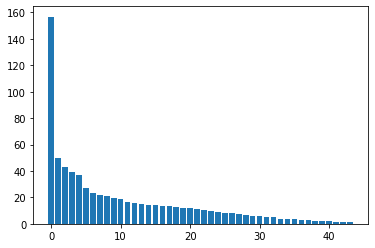

In [49]:
u, s, vt  = np.linalg.svd(bus_df_subset.iloc[:,:])
plt.bar(range(len(s)),s)
plt.show()


<BarContainer object of 44 artists>

Text(0.5, 1.0, 'Singular values of restaurant features')

Text(0.5, 0, 'Dimension')

Text(0, 0.5, 'Singular values')

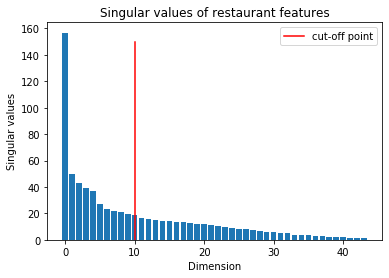

In [146]:
u, s, vt  = np.linalg.svd(bus_df_subset.iloc[:,:])
plt.bar(range(len(s)),s)
plt.plot([10 for i in np.linspace(0,150,10)], np.linspace(0,150,10),"r", label = "cut-off point")
plt.title("Singular values of restaurant features")
plt.xlabel("Dimension")
plt.ylabel("Singular values")
plt.legend(loc = "best")
plt.show()

In [149]:
np.cumsum(s**2/np.sum(s**2))[:10]

array([0.65611801, 0.72135899, 0.77086239, 0.81148973, 0.84739164,
       0.86647742, 0.88110888, 0.89351775, 0.90494873, 0.91512764])

### Choose top 10 singular values based on the above chart

In [26]:
   
def get_buscosine_sim(business,n_components):
    SVD = TruncatedSVD(n_components = n_components , random_state = 42) # 42 is the ultimate answer to everything
    bus_truncated = SVD.fit_transform(business)
    
    cosine_sim = cosine_similarity(bus_truncated, bus_truncated)
    return cosine_sim

### * the two types of similarity measures yield materially different distributions, to be tested for which is better

In [29]:
bus_cos_sim = get_buscosine_sim(bus_df_subset, 10)
df_cos_sim  = pd.DataFrame(bus_cos_sim, index= bus_df_subset.index.values, columns=bus_df_subset.index.values)
bus_cos_sim.shape

(1728, 1728)

### Tuning optimal values for k (neighbors), also test the two similarity measures

time elapsed: (seconds)
4269.55


optimal k (nearest neighbors):
   ks similarity sample_size      rmse       mae
1  15        cos       19500  1.336647  1.008416


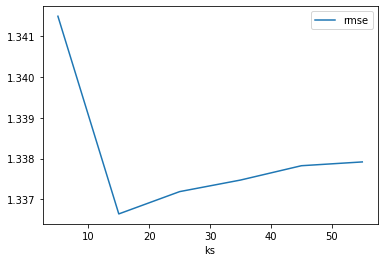

In [38]:
t0 = time.time()
df_pred_results_bus = pd.DataFrame(columns= ["ks", "similarity", "sample_size", "rmse", "mae"])
sample_sizes = [len(valid_df)]
ks = [5,15,25, 35, 45, 55]
similarity = ["cos" ]

for sim in similarity:
    if sim == "eucl":
        df_bus_sim = df_eucl_sim.copy()
    else:
        df_bus_sim = df_cos_sim.copy()
    
    for sample_size in sample_sizes:
        for k in ks:
            valid = CB_NLP_predict(train_df, valid_df.sample(n = sample_size, random_state = 12), df_bus_sim, k)
            rmse = mean_squared_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)**0.5
            mae = mean_absolute_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)
            df_pred_results_bus = df_pred_results_bus.append({"ks": k, "similarity": sim,  "sample_size": sample_size,
                                                      "rmse": rmse, "mae": mae}, ignore_index = True)
t1 = time.time()
print("time elapsed: (seconds)")
print(np.round(t1 - t0,3))

df_pred_results_bus[(df_pred_results_bus["sample_size"] == sample_size) &(df_pred_results_bus["similarity"] == "cos")].plot("ks", "rmse")
print("optimal k (nearest neighbors):")
print(df_pred_results_bus.loc[df_pred_results_bus["rmse"] == np.min(df_pred_results_bus.rmse) ,])

df_pred_results_bus.to_csv("../data/Content_Based_Filtering_Bus_nonNLP_Evaluation.csv",index = False)

(array([ 0., 10., 20., 30., 40., 50., 60.]),
 <a list of 7 Text xticklabel objects>)

(array([1.784, 1.786, 1.788, 1.79 , 1.792, 1.794, 1.796, 1.798, 1.8  ,
        1.802]),
 <a list of 10 Text yticklabel objects>)

Text(0.5, 0, 'k')

Text(0, 0.5, 'MSE')

Text(0.5, 1.0, 'Content Based Model (Restaurant Attribute): k vs MSE')

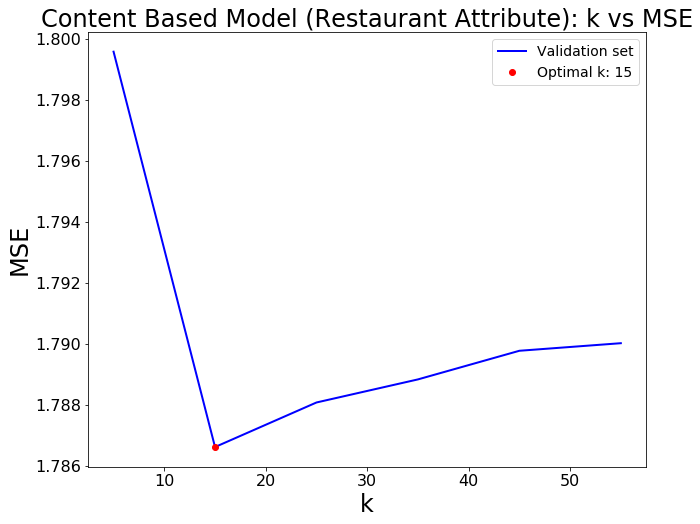

In [210]:
fig, ax = plt.subplots(figsize=(10,8))

optimal = df_pred_results_bus.loc[df_pred_results_bus["rmse"] == np.min(df_pred_results_bus.rmse),]

plt.plot(df_pred_results_bus["ks"], np.round(df_pred_results_bus["rmse"]**2,10), 
         label = "Validation set", linewidth = 2, color ="blue")
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.plot(optimal["ks"], np.round(optimal["rmse"]**2,10), "ro", label = "Optimal k: {}".format(15))
plt.legend(loc = "best", fontsize = 14)
plt.xlabel("k", fontsize = 24)
plt.ylabel("MSE", fontsize = 24)
plt.title("Content Based Model (Restaurant Attribute): k vs MSE",fontsize=24)

In [187]:
### Generate predictions using optimized parameters

t0 = time.time()
k = 15
    
valid = CB_NLP_predict(train_df, valid_df, df_cos_sim, k)
mse = mean_squared_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)
mae = mean_absolute_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)

t1 = time.time()
print("time elapsed: (seconds)")
print(np.round(t1 - t0,3))
print(mse)

valid.to_csv("../data/Predictions_CB_bus.csv",index = False)

time elapsed: (seconds)
1354.296
1.7866242990130192
